# Transformer Nueral Network


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time
import math

In [5]:
#Device miscellaneous
device = torch.device("cuda")   #or "cpu" for mac CPU
print(device)

cuda


In [6]:
torch.cuda.get_device_name()

'Tesla T4'

In [7]:
#Download data
train_data = torch.load("../data/twitter/train_data.pt")
train_label = torch.load("../data/twitter/train_label.pt")
train_actual_tweet = torch.load("../data/twitter/train_actual_tweet.pt")

test_data = torch.load("../data/twitter/test_data.pt")
test_label = torch.load("../data/twitter/test_label.pt")
test_actual_tweet = torch.load("../data/twitter/test_actual_tweet.pt")

idx2word = torch.load('../data/twitter/idx2word.pt')

In [8]:
#EDA
print("train_data type:", type(train_data), "\n")                   #train_data is a LIST of TENSORS
print("Size of train_data:", len(train_data), "\n")
print("Words in train_data[0]:", len(train_data[0]), "\n")
print("Index values of train_data[0]:",  train_data[0], "\n")
print("Tweet train_data[0]:", train_actual_tweet[0], "\n")
print("Sentiment label:", train_label[0], "\n")
print("Vocabulary size:", len(idx2word), "\n")
print("Vocabulary:", idx2word[0:50])

train_data type: <class 'list'> 

Size of train_data: 1428612 

Words in train_data[0]: 25 

Index values of train_data[0]: tensor([    0,   334,     0,   362,    21,     8,   124,    13,   105,    51,
         3610,     4,  1301,    21,    14,     7,   194, 10012,     2,    25,
          451,    17,     9,   187,    64]) 

Tweet train_data[0]: @idlewild_ @zaktar Stop that, or you'll go blind. Hahahaha that is the best threat I have seen in a long time 

Sentiment label: tensor(1) 

Vocabulary size: 30002 

Vocabulary: ['<unk>', '<pad>', 'i', '!', '.', 'to', ' ', 'the', ',', 'a', 'my', 'and', 'it', 'you', 'is', '?', '...', 'in', 'for', 'of', "'s", 'that', "n't", 'on', 'me', 'have', 'so', 'but', 'do', "'m", 'just', '-', 'with', 'be', 'was', 'at', 'not', '..', '&', 'this', 'now', ';', 'up', 'good', 'day', 'all', 'get', 'out', 'are', 'like']


In [9]:
#Attention Function
def scaled_dot_product_attention(Q, K, V):
    #Q & K: bs x nh x T x d_key
    #V: bs x nh x T x d_val

    d_key = K.shape[-1]
    Ã  = Q @ K.transpose(-2, -1) / math.sqrt(d_key)
    A = F.softmax(Ã, dim=-1)    #A: bs x nh x T x T

    Y = A @ V                   #Y: bs x nh x T x d_val

    return Y

In [10]:
#Multihead Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d, num_heads):           #class MultiHeadAttention takes 2 arguemnts (d and num_heads)
        super().__init__()

        assert d % num_heads == 0               #Mind this when choosing parameters (num_heads, d_in)
        d_key = d // num_heads
        d_val = d // num_heads

        self.linear_q = nn.Linear(d , num_heads * d_key, bias=False)
        self.linear_k = nn.Linear(d, num_heads * d_key, bias=False)
        self.linear_v = nn.Linear(d , num_heads * d_val, bias=False)
        self.linear_out = nn.Linear(d, d, bias=False)

        self.nh = num_heads
        self.dk = d_key
        self.dv = d_val


    def forward(self, x):                       # x is: bs x T x d
        # extract batchsize and length of the sequence
        bs = x.shape[0]
        T = x.shape[1]

        # compute query, keys and values
        Q = self.linear_q(x)                    # (bs, T, nh*dk)
        K = self.linear_k(x)                    # (bs, T, nh*dk)
        V = self.linear_v(x)                    # (bs, T, nh*dv)

        # reshape
        Q = Q.view(bs, T, self.nh, self.dk)     # (bs, T, nh, dk)
        K = K.view(bs, T, self.nh, self.dk)     # (bs, T, nh, dk)
        V = V.view(bs, T, self.nh, self.dk)     # (bs, T, nh, dv)

        # switch dimension so the head dimension is considered as a batch dimension
        Q = Q.transpose(1, 2)                   # (bs, nh, T, dk)
        K = K.transpose(1, 2)                   # (bs, nh, T, dk)
        V = V.transpose(1, 2)                   # (bs, nh, T, dv)

        # scaled dot product on batch of batch of T-by-dk and T-by-dv matrices
        Y = scaled_dot_product_attention(Q,K, V) # (bs, nh, T, dv)

        #reshape_2:
        # switch dimension back
        Y = Y.transpose(1, 2).contiguous()      # (bs, T, nh, dv)

        # reshape
        Y = Y.view(bs, T, self.nh * self.dv)    # (bs, T, nh*dv)

        # final linear layer
        Y = self.linear_out(Y)                 # (bs, T, nh*dv)            #Final linear layer W_o

        return Y

In [11]:
#MLP (Multi Layer Perceptron)
class MLP(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear_1 = nn.Linear(d, 4*d)       #4*d is convention
        self.linear_2 = nn.Linear(4*d, d)

    def forward(self, x):                       #x: bs x T x d
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)

        return x

In [12]:
#Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()

        #Assigning attributes
        self.d = d
        self.num_heads = num_heads

        #Layer Normalization
        self.mod_layernorm = nn.LayerNorm(d, elementwise_affine=False)

        #MLP block
        self.MLP_block = MLP(d)

        #Attention block
        self.attention_block = MultiHeadAttention(d, num_heads)


    def forward(self, x):

        #Layer Normalization
        x_ln = self.mod_layernorm(x)

        #Multi-Head Attention
        y =self.attention_block(x_ln)

        #Layer Normalization
        y_ln = self.mod_layernorm(y)

        #MLP
        z = self.MLP_block(y_ln)

        #Residual connection
        output = x + y + z

        return output

In [13]:
#Transformer Architecture
class Transformer(nn.Module):
    def __init__(self, d, blocks, num_heads):       #input is x: bs x T x d_in
        super().__init__()

        #Assigning attributes
        self.d = d
        self.blocks = blocks
        self.num_heads = num_heads
        self.max_length = 183                              #Whatever the LONGESET sequence/tweet in the minibatch is

        #Embedding modules
        self.mod_embed = nn.Embedding(30002, d)     #30,002 is the size of the vocabulary. What embedding dimension should we choose?
        self.mod_pos = nn.Embedding(self.max_length, d)

        #Final binary classification layer
        self.W_v = nn.Linear(d, 2)

        #_n_ transformer blocks
        transformer_list = []
        for i in range(blocks):
            mod = TransformerBlock(d, num_heads)
            transformer_list.append(mod)
        self.transformers = nn.ModuleList(transformer_list)


    def forward(self, x):

        #Variable assignment
        bs = x.shape[0]

        #Word embeddings
        x = self.mod_embed(x)                 #Slides Transformers_2: y = mod(minibatch)      (mod = nn.Embedding(diction, d_in))

        #Transformer blocks
        for i in range(self.blocks):
            transformer_block = self.transformers[i]
            x = transformer_block(x)

        #Average
        z = x.mean(dim=1)                           #Choose so that dim=T so that we are left with bs x d_in (x 1)

        #V linear layer
        #RESHAPE z FOR SIZE-COMPATIBILITY
        z = z.view(bs, self.d)
        result = self.W_v(z)

        return result

In [14]:
#Network instantiation
d_in = 120          #100-1000                        #d_in / #heads has to be an integer!           # d_val = d_key = d_in / # heads
blocks = 4          #4-12 transformer blocks
num_heads = 6       #6, 8, 10, 12 heads

net = Transformer(d_in, blocks, num_heads)

#Send network to GPU
net = net.to(device)

In [16]:
#Training-Loop Miscellaneous
lr = 0.0001
optimizer = optim.AdamW(net.parameters(), lr, weight_decay=0.1, betas=(0.9, 0.95))
criterion = nn.CrossEntropyLoss()
bs = 200


#Training Phase
start=time.time()
epochs = 10

for epoch in range(epochs):
    if epoch == 4:
        lr = lr / 10

    optimizer = optim.AdamW(net.parameters(), lr, weight_decay=0.1, betas=(0.9, 0.95))

    running_loss=0
    running_error=0
    num_batches=0

    shuffled_indices=torch.randperm(len(train_data))

    for count in range(0, len(train_data), bs):

        #Set gradients to zero
        optimizer.zero_grad()

        #Create minibatch
        indices = shuffled_indices[count:count+bs]     #syntax?
        minibatch_data, minibatch_label = utils.make_minibatch(indices, train_data, train_label)

        #Send minibatch to GPU
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        #Forward minibatch through net
        scores = net(minibatch_data)

        #Compute average loss in minibatch
        loss = criterion(scores, minibatch_label)

        #Backward pass (computing dL/dW's)
        loss.backward()

        #One step of SGD
        optimizer.step()

        #COMPUTING STATS------------------------------
        num_batches+=1

        with torch.no_grad():

            running_loss += loss.item()

            error = utils.get_error( scores , minibatch_label)
            running_error += error.item()


    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start

    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    print(' ')

epoch= 0 	 time= 163.80912160873413 	 loss= 0.47790410760101787 	 error= 23.259940290404327 percent
 
epoch= 1 	 time= 334.0300672054291 	 loss= 0.43108728731182494 	 error= 20.204602589065257 percent
 
epoch= 2 	 time= 504.0011169910431 	 loss= 0.4138619192653781 	 error= 19.159343151202528 percent
 
epoch= 3 	 time= 674.3262350559235 	 loss= 0.40226072930675605 	 error= 18.51243660404594 percent
 
epoch= 4 	 time= 845.0933473110199 	 loss= 0.3822848780679309 	 error= 17.408829833164997 percent
 
epoch= 5 	 time= 1015.5987076759338 	 loss= 0.3773609170250069 	 error= 17.146161884436548 percent
 
epoch= 6 	 time= 1185.9882292747498 	 loss= 0.37440217522464164 	 error= 16.978958647068243 percent
 
epoch= 7 	 time= 1356.6270315647125 	 loss= 0.3718056544236013 	 error= 16.834408444459868 percent
 
epoch= 8 	 time= 1527.0652039051056 	 loss= 0.3693931381794867 	 error= 16.72646234026815 percent
 
epoch= 9 	 time= 1697.8906610012054 	 loss= 0.3670351619061504 	 error= 16.583288616989922 pe

TWEET: <unk> cheers . still no phone call i reckon they will wait till the end of the day
LABEL tensor(1)


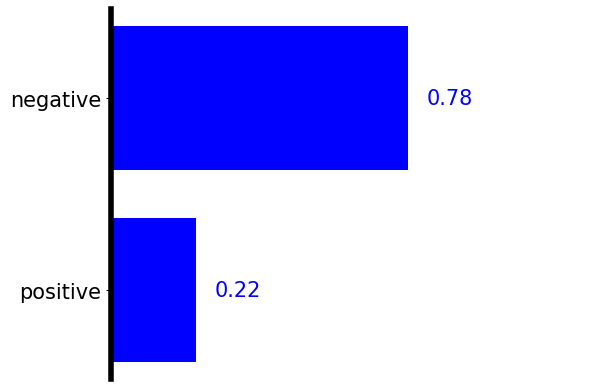

In [17]:
idx=randint(0, len(test_data) - 1)
tweet = test_data[idx]

text_tweet = utils.tensor2text(tweet)
label = train_label[idx]

tweet = tweet.to(device)
input = tweet.view(1,tweet.size(0))
p = net(input)

print('TWEET:', text_tweet )
print('LABEL' , label )
probs= F.softmax(p, dim=1)
utils.show_prob(probs)

TWEET: Just had the best day ever ! Sunshine, good vibes, and accomplished all my goals . #Grateful


tensor([[  30,   77,    7,  194,   44,  243,    3,    0,   43,    0,   11, 3894,
           45,   10, 5650,    4,    0]], device='cuda:0')




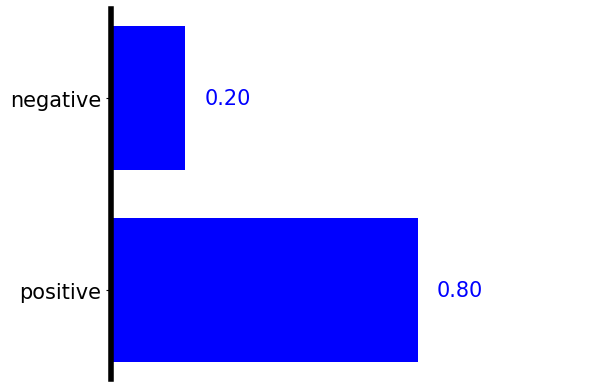

In [29]:
tweet_text = "Just had the best day ever ! Sunshine, good vibes, and accomplished all my goals . #Grateful"
tweet = utils.text2tensor(tweet_text)
tweet = tweet.view(1,tweet.size(0))
tweet = tweet.to(device)

p = net(tweet)
p= F.softmax(p, dim=1)

print("TWEET:", tweet_text)
print("\n")
print(tweet )
print("\n")
utils.show_prob(p)

TWEET: Amazing teamwork at the office today ! Everyone pitched in and we nailed the project . #TeamworkMakesTheDreamWork


tensor([[  252,     0,    35,     7,   512,    53,     3,   202, 15349,    17,
            11,    58, 11260,     7,   925,     4,     0]], device='cuda:0')




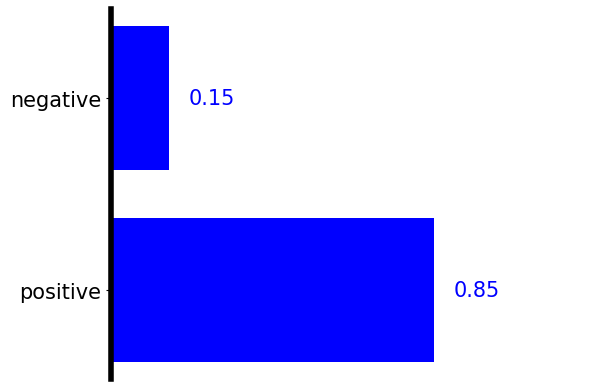

In [21]:
tweet_text = "Amazing teamwork at the office today ! Everyone pitched in and we nailed the project . #TeamworkMakesTheDreamWork"
tweet = utils.text2tensor(tweet_text)
tweet = tweet.view(1,tweet.size(0))
tweet = tweet.to(device)

p = net(tweet)
p= F.softmax(p, dim=1)

print("TWEET:",tweet_text)
print("\n")
print(tweet )
print("\n")
utils.show_prob(p)

TWEET: Had a terrible experience at the customer service today. Zero help, zero empathy. #CustomerServiceFail


tensor([[  77,    9, 1033, 1440,   35,    7, 2923, 1006,    0, 3185,    0, 3185,
            0,    0]], device='cuda:0')




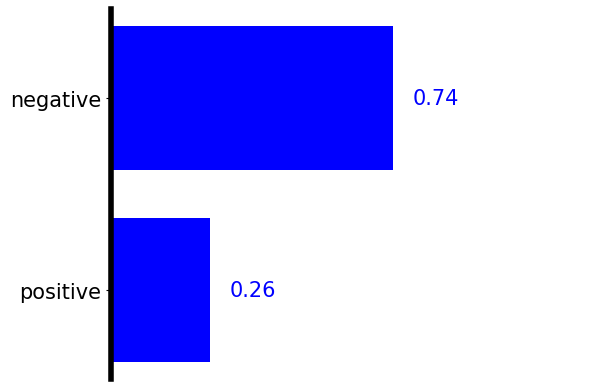

In [24]:
tweet_text = "Had a terrible experience at the customer service today. Zero help, zero empathy. #CustomerServiceFail"
tweet = utils.text2tensor(tweet_text)
tweet = tweet.view(1,tweet.size(0))
tweet = tweet.to(device)

p = net(tweet)
p= F.softmax(p, dim=1)

print("TWEET:",tweet_text)
print("\n")
print(tweet)
print("\n")
utils.show_prob(p)

TWEET: Attended an interesting webinar on artificial intelligence. Always learning something new. #ContinuousLearning


tensor([[ 7900,   113,   705, 14260,    23, 22082,     0,   214,  1307,   223,
             0,     0]], device='cuda:0')




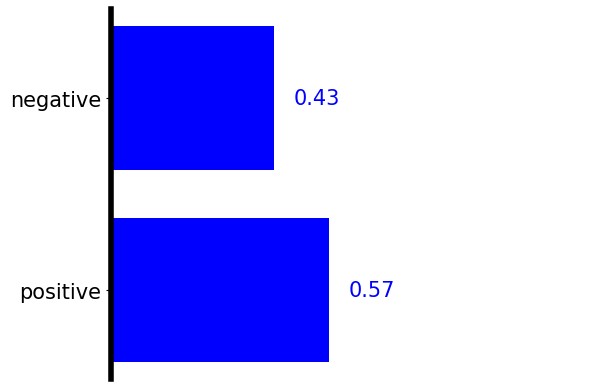

In [25]:
tweet_text = "Attended an interesting webinar on artificial intelligence. Always learning something new. #ContinuousLearning"
tweet = utils.text2tensor(tweet_text)
tweet = tweet.view(1,tweet.size(0))
tweet = tweet.to(device)

p = net(tweet)
p= F.softmax(p, dim=1)

print("TWEET:",tweet_text)
print("\n")
print(tweet)
print("\n")
utils.show_prob(p)

TWEET: Impressed with how our company swiftly responded to the crisis. Clear communication, proactive measures, and a united front. 


tensor([[ 2092,    32,    81,   208,  1040,     0,  5585,     5,     7,     0,
          1798,     0, 20315,     0,    11,     9,  3530,     0]],
       device='cuda:0')




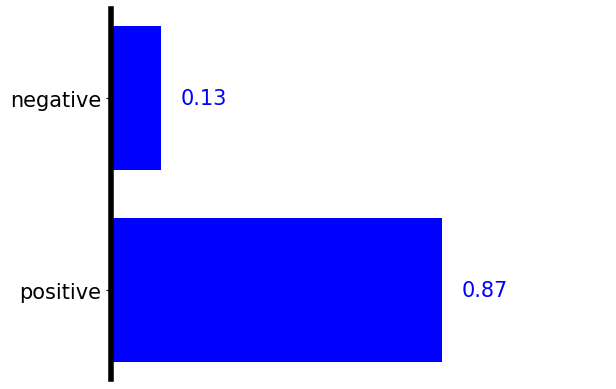

In [26]:
tweet_text = "Impressed with how our company swiftly responded to the crisis. Clear communication, proactive measures, and a united front. "
tweet = utils.text2tensor(tweet_text)
tweet = tweet.view(1,tweet.size(0))
tweet = tweet.to(device)

p = net(tweet)
p= F.softmax(p, dim=1)

print("TWEET:",tweet_text)
print("\n")
print(tweet)
print("\n")
utils.show_prob(p)